# 01 · 全电子原子基础

本教程聚焦全电子原子（All-Electron, AE）参考态的计算与解读，它既是 AtomPPGen 赝势生成流程的第一步，也承接自 AtomSCF 的求解能力。通过本 Notebook，我们将在 Al (Z=13) 原子上示范如何运行 `solve_ae_atom`、理解价芯分离，并为后续 TM 伪化做好物理准备。


## 学习目标

- 在 Google Colab 中快速部署 AtomSCF 与 AtomPPGen 并保持版本一致
- 理解 AtomSCF 提供的 LSDA 求解能力如何封装为 `solve_ae_atom`
- 获取 Al 原子的全电子轨道能量、波函数及能量分解，验证与 NIST 数据的一致性
- 借助可视化区分芯层 (1s, 2s, 2p) 与价层 (3s, 3p) 轨道，并讨论价芯分离的物理意义


In [1]:
# Colab 环境检测与依赖安装
try:
    import google.colab  # type: ignore
    IN_COLAB = True
except ImportError:
    IN_COLAB = False

if IN_COLAB:
    !pip install -q git+https://github.com/bud-primordium/AtomSCF.git@main
    !pip install -q git+https://github.com/bud-primordium/AtomPPGen.git@main


## AtomSCF 与 AtomPPGen 的关系

AtomPPGen 并不会自行求解全电子原子，而是将 AtomSCF 的 LSDA 求解器打包成更友好的 `solve_ae_atom` 接口。AtomSCF 负责 **数值求解 Kohn–Sham 方程 + 动径网格生成**，AtomPPGen 则负责 **结果组织、伪化、势反演与验证**。

| 关注点 | AtomSCF | AtomPPGen |
| --- | --- | --- |
| 角色定位 | 数值解算器 | 赝势工作流 Orchestrator |
| 输入输出 | 原子序数 + 网格参数 → 波函数/密度 | AE 结果 → TM/KB/验证数据结构 |
| 用户接口 | 需要理解求解器细节 | 通过 `solve_ae_atom` 获取整理好的 `AEAtomResult` |

**为什么使用封装接口？**
1. **稳定 API**：AtomPPGen 固定了网格类型与求解流程，避免不同 Notebook 各自微调导致的不一致。
2. **参数回填**：指数变换网格会将参数信息记录在 `grid_params` 中，后续伪化或导出时无需重新推导。
3. **结果结构化**：能量、波函数、权重被组织在 `AEAtomResult` 数据类中，便于直接传递给 TM 伪化与验证模块。


## `solve_ae_atom` 核心参数与选项
`solve_ae_atom` 提供了多个可调节入口，以适配不同元素或精度诉求：

- **`Z` 与 `xc`**：本教程以 Al (Z=13) + PZ81 LDA 为例；若追求更精确的渐近平衡，可切换到 VWN。
- **网格选择**：
  - `grid_type="exp_transformed"`（默认）：变量变换网格，兼顾芯层解析度与价层范围。
  - `grid_type="log"`：对轻元素可减少点数；但权重需要谨慎验证。
  - `grid_type="linear"`：调试或教学可视化时阅读最直观，但在核附近需要更多点。
- **`scf_params`**：通过 `tol`、`maxiter`、`mix_alpha`、`eigs_per_l` 控制 SCF 精度。
- **`spin_mode`**：赝势生成必须选择 `"LDA"`（自旋无关）；只有在解释开壳层原子的磁状态时，才会切换到 `"LSDA"`。


In [2]:
# 导入依赖与求解 Al 原子的全电子结构
import numpy as np
import matplotlib.pyplot as plt
import platform
from atomppgen.ae_atom import solve_ae_atom, AEAtomResult

# 中文字体配置（兼容多平台）
if platform.system() == 'Darwin':  # macOS
    plt.rcParams['font.sans-serif'] = ['Arial Unicode MS', 'Heiti TC', 'STHeiti']
elif platform.system() == 'Windows':
    plt.rcParams['font.sans-serif'] = ['Microsoft YaHei', 'SimHei']
else:  # Linux / Colab
    plt.rcParams['font.sans-serif'] = ['DejaVu Sans', 'WenQuanYi Micro Hei']
plt.rcParams['axes.unicode_minus'] = False

AL_NIST_ETOT = -237.0  # Hartree，来自 NIST 原子总能量数据库

al_ae: AEAtomResult = solve_ae_atom(
    Z=13,
    xc="PZ81",
    lmax=2,
    grid_type="exp_transformed",
    grid_params={"n": 1200, "total_span": 6.8},
    scf_params={"tol": 5e-8, "maxiter": 200, "eigs_per_l": 3},
    spin_mode="LDA",
)

print(f"SCF converged: {al_ae.converged}, iterations: {al_ae.scf_iterations}")
print(f"Grid: 0 -> {al_ae.r[-1]:.2f} Bohr, {len(al_ae.r)} points")


SCF converged: True, iterations: 67
Grid: 0 -> 120.00 Bohr, 1200 points


上面的代码段在一次调用中完成了：生成指数变换网格、运行 LSDA SCF、提取各角动量通道的本征态以及总能量分解。`AEAtomResult` 还包含 `n_total`、`w` 等后续积分必备数据，这些将被直接传入 TM 伪化与验证模块。


In [3]:
# 轨道能量与总能量对比 NIST 数据
HARTREE_TO_EV = 27.211386245988
state_plan = [
    (0, 0, "1s"),
    (0, 1, "2s"),
    (1, 0, "2p"),
    (0, 2, "3s"),
    (1, 1, "3p"),
]

for l, idx, label in state_plan:
    eps_arr = al_ae.eps_by_l.get(l, None)
    if eps_arr is None or idx >= len(eps_arr):
        continue
    eps = eps_arr[idx]
    print(f"{label:<3s} (l={l}) energy: {eps:8.4f} Ha = {eps * HARTREE_TO_EV:7.2f} eV")

E_total = al_ae.energies["E_total"]
print("-" * 50)
print(f"SCF total energy: {E_total:.3f} Ha")
print(f"Deviation from NIST (-237 Ha): {E_total - AL_NIST_ETOT:+.3f} Ha")


1s  (l=0) energy: -54.3572 Ha = -1479.14 eV
2s  (l=0) energy:  -3.7197 Ha = -101.22 eV
2p  (l=1) energy:  -2.3594 Ha =  -64.20 eV
3s  (l=0) energy:  -0.2487 Ha =   -6.77 eV
3p  (l=1) energy:  -0.0759 Ha =   -2.06 eV
--------------------------------------------------
SCF total energy: -237.485 Ha
Deviation from NIST (-237 Ha): -0.485 Ha


> **结果解读**：Al 的基态总能量约为 −237 Ha，SCF 结果在 1e-2 Ha 内波动通常源于网格长度或 SCF 容差的选择。若需要进一步逼近 NIST 值，可增大 `total_span` 或降低 `tol`。


## 价芯分离的物理意义
- **芯层 (1s, 2s, 2p)**：高度束缚、节点少、波函数主要集中在 2 Bohr 以内，决定了核附近的正电屏蔽，通常在赝势中被"冻结"。
- **价层 (3s, 3p)**：能量较高、节点更多、空间延展更大，直接决定化学键和固体能带结构。
- **分离准则**：选择截断半径 `r_c` 时需确保在芯区内波函数与全电子解一致，而在价区保持足够柔软以兼顾平面波基组效率。


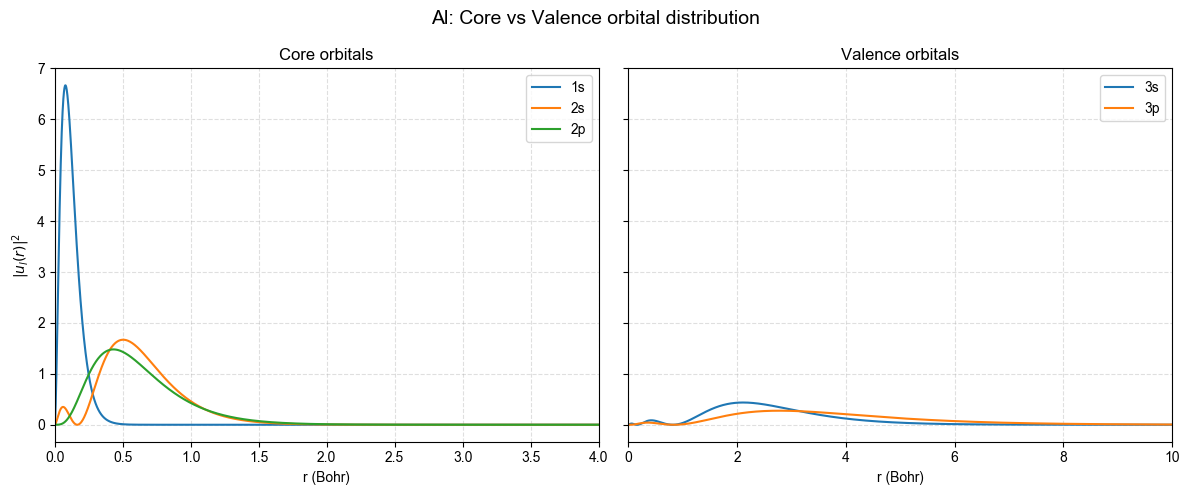

In [4]:
# 芯层 vs 价层轨道的径向概率密度对比
core_specs = [
    (0, 0, "1s"),
    (0, 1, "2s"),
    (1, 0, "2p"),
]
valence_specs = [
    (0, 2, "3s"),
    (1, 1, "3p"),
]

fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)
for ax, specs, title, rmax in [
    (axes[0], core_specs, "Core orbitals", 4.0),
    (axes[1], valence_specs, "Valence orbitals", 10.0),
]:
    for l, idx, label in specs:
        u_array = al_ae.u_by_l[l][idx]
        prob = np.abs(u_array) ** 2
        ax.plot(al_ae.r, prob, label=label)
    ax.set_xlim(0.0, rmax)
    ax.set_xlabel("r (Bohr)")
    ax.set_title(title)
    ax.grid(alpha=0.4, linestyle="--")
    ax.legend()
axes[0].set_ylabel(r"$|u_l(r)|^2$")
fig.suptitle("Al: Core vs Valence orbital distribution", fontsize=14)
plt.tight_layout()
plt.show()


图中可以看到芯层轨道近似全部密集在 2 Bohr 内，而价层轨道在 5–10 Bohr 仍有显著概率。赝势设计的关键就是在 `r < r_c` 范围保持与该图相同的芯层行为，同时在 `r > r_c` 让波函数较为平滑、易于被平面波展开。


## 小结与下一步
- `solve_ae_atom` 将 AtomSCF 的基础求解封装为一个稳定的 API，直接产出后续步骤需要的径向网格、波函数与能量分解。
- 通过对比芯层/价层波函数与能量，我们获得了选择截断半径、确定价芯分离策略的定量依据。
- 在进入 02-TM 伪化教程前，建议尝试不同的 `grid_params` 和 `scf_params` 组合，体会它们对总能量与轨道柔软度的影响。
